# はじめに：必要なファイル  
jupyterと同階層にsub_modelフォルダを作成し、下記ファイルを配置のこと  
階層やファイル名を変更したい場合は、”モジュールをインポート”と”データとモデルファイルをインポート”においてpathを変更してください(計2箇所)

## データ
・master_10min.csv  
## モデルファイル  
### ベルヌーイの定理係数推定モデル
・est_rho_model.sav  
### つまり-操作量(cl)モデル
・est_cl_model.sav  
### スケーラー
・fouling_scaler.sav  
## 関数ファイル
・LVMWD_fouling_submodel.py

# モジュールをインポート

In [1]:
#本番でも必要
from sub_model import LVMWD_fouling_submodel # ファイルパスを変更する場合fromの部分を変える必要あり
import pickle
import numpy as np
#動作確認のみに使用
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

# データとモデルファイルをインポート

In [2]:
# ファイルを直下に移動したくない場合は変更
base_folder_path = "sub_model/" 
csv_10min_path = base_folder_path + "master_10min.csv"
#データをdf化
df10 = pd.read_csv(csv_10min_path, delimiter=',', encoding = "cp932", header=0)
df10['timestamp'] = pd.to_datetime(df10['timestamp'])
# model file をインポート
filename = 'est_rho_model.sav'
est_rho_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'est_cl_model.sav'
est_cl_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'fouling_scaler.sav'
loaded_scaler = pickle.load(open(base_folder_path + filename, 'rb'))

# 使用するデータを抜き出し、移動平均処理

In [3]:
tag_list = ["LasVirgenes/UF/PT_41095/Val","LasVirgenes/UF/PT_41945/Val","LasVirgenes/UF/FIT_41074/Val","LasVirgenes/UF/FIT_41274/Val"
            ,"LasVirgenes/UF/FIT_41374/Val","LasVirgenes/UF/FIT_41974/Val","LasVirgenes/UF/AI_31094/Val"]

In [4]:
use_data = df10[tag_list].to_numpy()#データの抜き出し
num = 6 *12#移動平均の個数
row, col = np.shape(use_data)
ave_data = np.zeros((row-num+1)*col).reshape(-1,col)
weight=np.ones(num)/num
for n in range(col):
    ave_data[:,n] = np.convolve(use_data[:,n], weight, mode='valid')#移動平均

# foulingの計算

In [5]:
print("ave_dataのサイズは行方向はデータ点数（任意の数）",np.shape(ave_data)[0],"列方向はタグ数 = ",np.shape(ave_data)[1])

ave_dataのサイズは行方向はデータ点数（任意の数） 120393 列方向はタグ数 =  7


In [6]:
fouling_scale = LVMWD_fouling_submodel.cal_fouling(ave_data,est_rho_model,loaded_scaler)

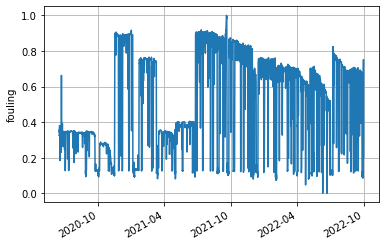

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.autofmt_xdate()
plt.rcParams['font.family'] = "MS Gothic"
locator = mdates.MonthLocator(interval=6)
ax.plot(df10['timestamp'][num-1:],fouling_scale)
# ax.set_ylim([0.0,0.1])
ax.xaxis.set_major_locator(locator)
ax.set_ylabel("fouling")
plt.grid()

# つまり変化量の計算

In [8]:
delta_fouling = LVMWD_fouling_submodel.cal_delta_fouling(ave_data,est_cl_model)

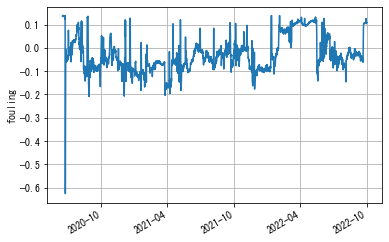

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.autofmt_xdate()
plt.rcParams['font.family'] = "MS Gothic"
locator = mdates.MonthLocator(interval=6)
ax.plot(df10['timestamp'][num-1:],delta_fouling.reshape(-1))
# ax.set_ylim([0.0,0.1])
ax.xaxis.set_major_locator(locator)
ax.set_ylabel("fouling")
plt.grid()

# 制約への変換

$fouling\_scale - delta\_fluling < th$

を満たすように、$delta\_fluling < th$の説明変数である$UF Filtrate Total Chlorine $を変化させる。  
th はつまったことの根魚がないため明確な設定値はなし。  
0.6 ~ 0.8程度に設定すると検証しやすいと思われます。 

# 中身確認用

In [16]:
def cal_delta_fouling(ave_data,est_cl_model):
    delta_fouling =  ave_data[:,6] *  est_cl_model.coef_ + est_cl_model.intercept_ 
    return delta_fouling

In [17]:
def cal_fouling(ave_data,est_rho_model,loaded_scaler):
    begin = 0
    end = len(ave_data)
    gmp_trans = 3.785/60

    pa = (ave_data[begin:end,0] - 44 - 18 - 14 - ave_data[begin:end,1]) * 6895
    v2 = (((ave_data[begin:end,2]+ave_data[begin:end,3]+ave_data[begin:end,4]+ave_data[begin:end,5])*gmp_trans)**2 - (ave_data[begin:end,2]*gmp_trans)**2 - (ave_data[begin:end,3]*gmp_trans)**2 
          - (ave_data[begin:end,4]*gmp_trans)**2 - (ave_data[begin:end,5]*gmp_trans)**2)/2
    fouling = pa + v2/est_rho_model.coef_
    fouling_scale = loaded_scaler.transform(fouling.reshape(-1,1))
    return fouling_scale